<a href="https://colab.research.google.com/github/pejmanrasti/JFMS_2025/blob/main/Surface_Crack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Make your first experience with TensorFlow-Keras**
Our goal is to construct and train a convolutional neural network (CNN) on thousands of concrete surface images in order to detect the presence of cracks. The dataset used is the Surface Crack Detection dataset, which contains images categorized into two classes: 'Positive' (crack present) and 'Negative' (no crack). This hands-on example will help us understand how deep learning models can be applied to real-world civil engineering problems like structural inspection.

# **Importing necessary Libraries**

In [1]:
from tensorflow.keras.models import Sequential # Model type to be used
from tensorflow.keras.layers import Dense, Activation, Dropout# Make Fully connected (FC) layers
from tensorflow.keras.utils import to_categorical # NumPy related tools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
import tensorflow as tf

import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
from glob import glob
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep
from tqdm.notebook import tqdm
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix
import seaborn as sns
import kagglehub
import os
import shutil
import random
! pip install livelossplot
from livelossplot import PlotLossesKeras

sns.set()


## Loading Training and Validation Data

The Surface Crack Detection dataset is not included in Keras by default. Therefore, we load it manually from a directory structure where images are stored in subfolders named 'Positive' and 'Negative'. We will read, preprocess, and label the images accordingly to prepare them for training and validation using TensorFlow/Keras.

In [2]:
# Download latest version
path = kagglehub.dataset_download("arunrk7/surface-crack-detection")


# Create the destination directory if it doesn't exist
destination_dir = "/content/data"
os.makedirs(destination_dir, exist_ok=True)

# Copy the downloaded files to the new directory
for filename in os.listdir(path):
    source_path = os.path.join(path, filename)
    destination_path = os.path.join(destination_dir, filename)
    if os.path.isfile(source_path):
        shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
    elif os.path.isdir(source_path):
      shutil.copytree(source_path, destination_path)

print("Files copied to:", destination_dir)


Files copied to: /content/data


In [3]:
negative = glob('/content/data/Negative/*')
positive = glob('/content/data/Positive/*')

In [4]:
# Limit to 1000 images per class
negative_files = negative[:2000]
positive_files = positive[:2000]

images = []
labels = []

for img_path in negative_files:
  img = cv2.imread(img_path)
  img = cv2.resize(img, (128, 128))
  #img = rgb2gray(img) #convert to grayscale
  images.append(img)
  labels.append(0)

for img_path in positive_files:
  img = cv2.imread(img_path)
  img = cv2.resize(img, (128, 128))
  #img = rgb2gray(img) #convert to grayscale
  images.append(img)
  labels.append(1)

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)


# Split data into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42
)
# Split data into train and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)



Visualization of some input images

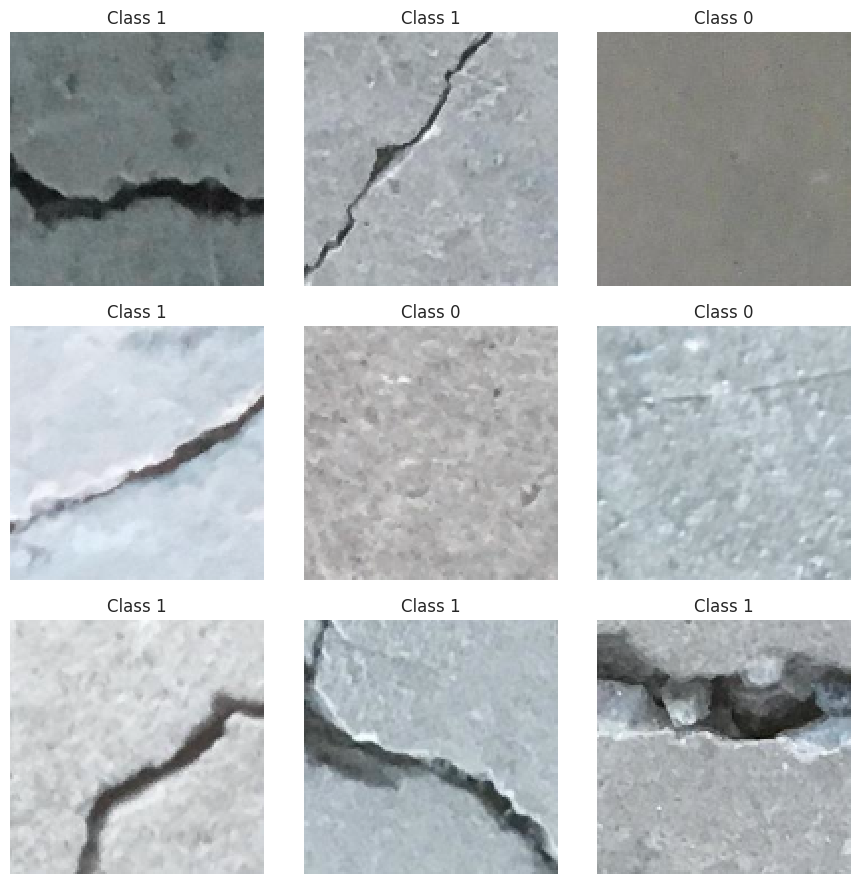

In [5]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    plt.axis('off') # Remove the axis and gridlines

plt.tight_layout()

## Formatting the Input Data Layer

All images are resized to 128×128 pixels and converted to grayscale. Since we are using a Multi-Layer Perceptron (MLP), each image is flattened into a one-dimensional vector of length 16,384 (128 × 128) before being fed into the network.

In [6]:
# Get the correct number of features based on image dimensions
num_features = X_train.shape[1] * X_train.shape[2]* X_train.shape[3]

# Reshape X_train and X_val using the calculated num_features
X_train = X_train.reshape(X_train.shape[0], num_features).astype('float32')
X_val = X_val.reshape(X_val.shape[0], num_features).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train /= 255.
X_val /= 255.

We then modify our classes (unique digits) to be in the one-hot format, i.e.

In [7]:
# one hot encode outputs
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)

# Building the simplest fully connected network (FCN) with just one layer

In [8]:
# The Sequential model is a linear stack of layers and is very common.
model = Sequential([
    Dense(2,input_shape=(num_features,)), # It is the output layer and should be equal to the number of desired classes (10 in this case).
    Activation('softmax'),
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │        98,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,306 (384.01 KB)

 Trainable params: 98,306 (384.01 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

When compiling a model in Keras, we define the loss function and the optimizer used during training. For our binary classification task (cracked vs. non-cracked surfaces), we use the binary cross-entropy loss function, which is well-suited for comparing predicted probabilities to binary class labels.

The optimizer we use is Adam, a widely used method that adjusts the learning rate during training. The model’s output is a probability indicating whether an image is cracked or not, and binary cross-entropy helps measure how close this prediction is to the actual label.

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train the model!

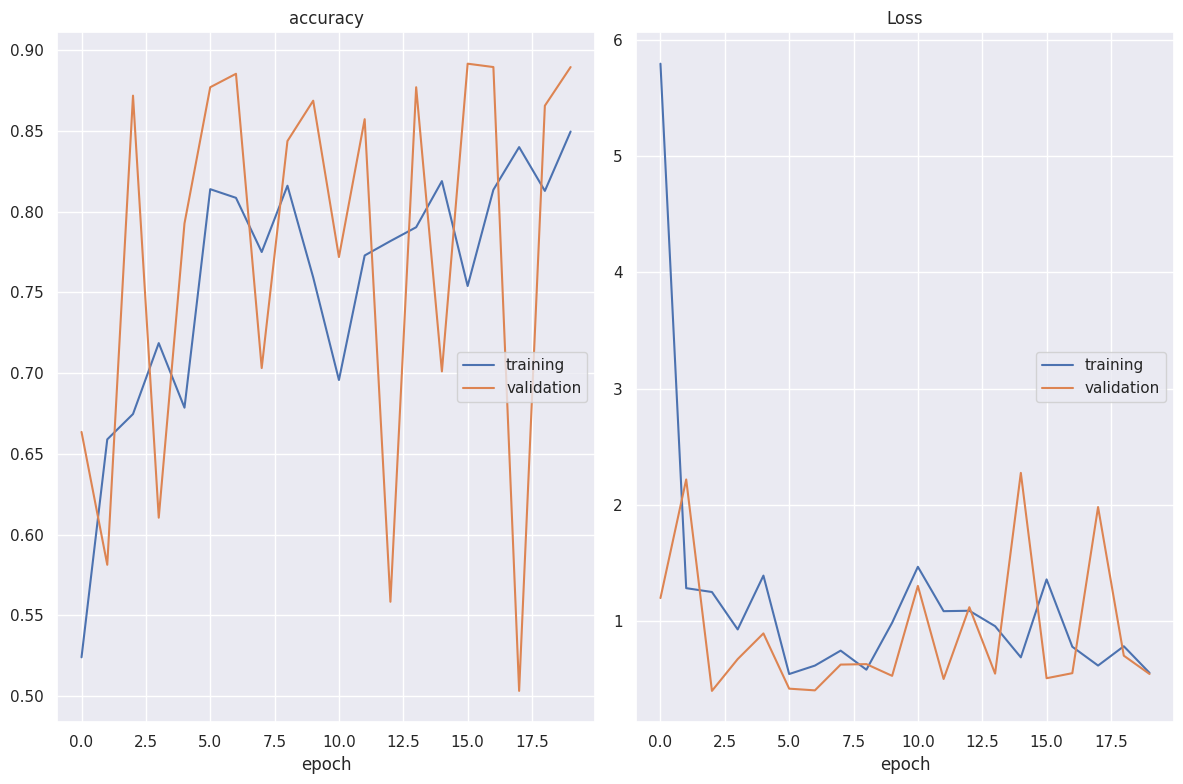

accuracy
	training         	 (min:    0.524, max:    0.850, cur:    0.850)
	validation       	 (min:    0.503, max:    0.892, cur:    0.890)
Loss
	training         	 (min:    0.544, max:    5.795, cur:    0.553)
	validation       	 (min:    0.399, max:    2.274, cur:    0.544)
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8405 - loss: 0.5872 - val_accuracy: 0.8896 - val_loss: 0.5440


In [10]:
plotlosses = PlotLossesKeras()
model.fit(X_train, Y_train,
          validation_data=(X_val, Y_val),
          epochs=20, batch_size=32,
          verbose=1,
          callbacks=[plotlosses])

## Evaluate Model's Accuracy on Test Data
Your test data **Must** be different from the validation data, but in this example, we will use the validation data as the test data as well.

In [11]:
Y_test = to_categorical(y_test)
X_test = X_test.reshape(X_test.shape[0], num_features).astype('float32')
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8937 - loss: 95.8260
Test score: 70.4179458618164
Test accuracy: 0.8999999761581421


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [12]:
# The predict function outputs the probabilities for each class
# np.argmax finds the index of the class with the highest probability
predicted_classes = np.argmax(model.predict(X_val), axis=-1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_val)[0]

incorrect_indices = np.nonzero(predicted_classes != y_val)[0]

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


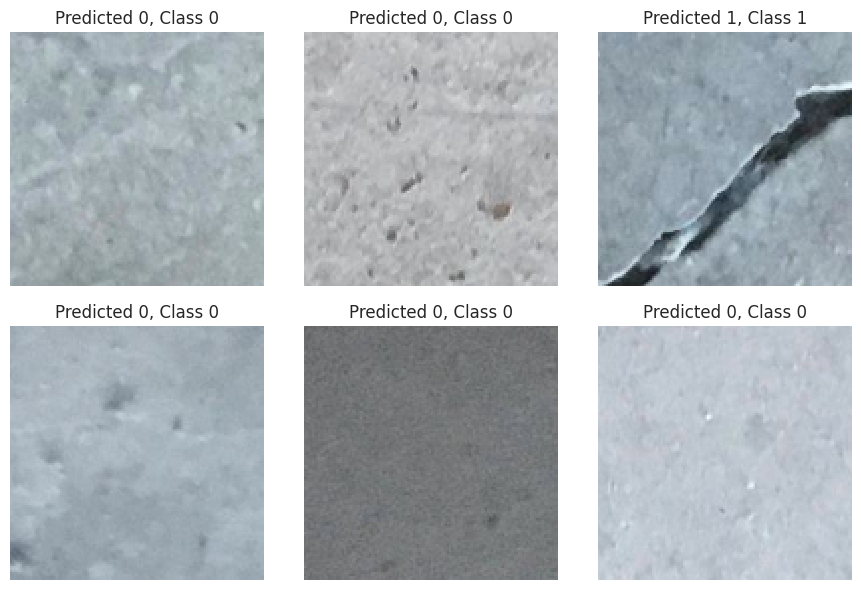

In [15]:
plt.figure()
for i, correct in enumerate(correct_indices[:6]):
    plt.subplot(3,3,i+1)
    # Reshape to the original image size (128x128x3)
    plt.imshow(X_val[correct].reshape(128,128,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_val[correct]))
    plt.axis('off') # Remove the axis and gridlines

plt.tight_layout()


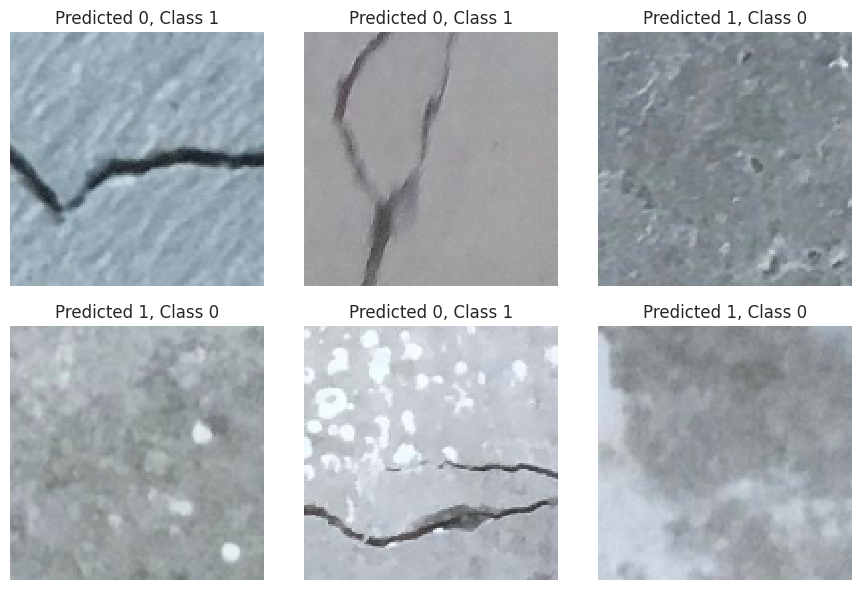

In [16]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:6]):
    plt.subplot(3,3,i+1)
    # Reshape to the original image size (128x128x3)
    plt.imshow(X_val[incorrect].reshape(128,128,3), cmap='gray', interpolation='none') # Changed reshape to (128, 128, 3)
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_val[incorrect]))
    plt.axis('off') # Remove the axis and gridlines

plt.tight_layout()

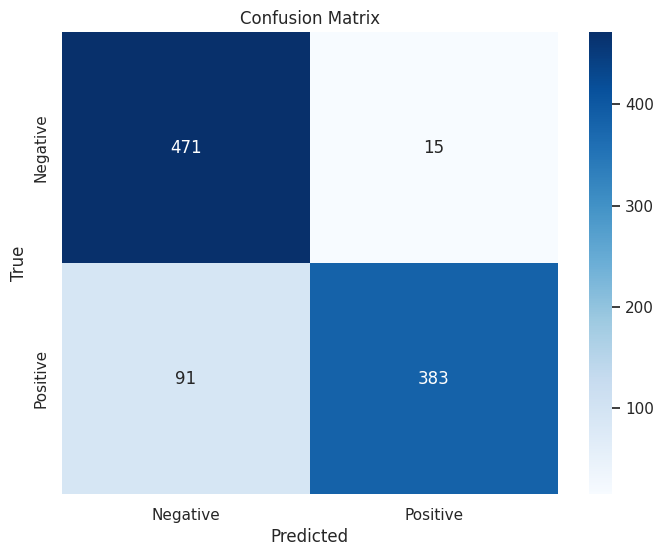

In [17]:
# Assuming 'predicted_classes' and 'y_val' are defined as in your provided code.
cm = confusion_matrix(y_val, predicted_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# **Let's go Deeper**
We will add four more layers to our model. We use Droupout in our model to reduce overfitting

In [18]:
# Dropout helps protect the model from memorizing or "overfitting" the training data.
Pkeep=0.25
modelDeepFC = Sequential([
    Dense(200, input_shape=(num_features,)),
    Activation('relu'),
    Dropout(Pkeep),
    Dense(100, input_shape=(200,)),
    Activation('relu'),
    Dropout(Pkeep),
    Dense(60, input_shape=(100,)),
    Activation('relu'),
    Dropout(Pkeep),
    Dense(30, input_shape=(60,)),
    Activation('relu'),
    Dropout(Pkeep),
    Dense(2),
    Activation('softmax'),
])
modelDeepFC.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 200)            │     9,830,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60)             │         6,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            62 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,858,652 (37.61 MB)

 Trainable params: 9,858,652 (37.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
plotlossesdeeper = PlotLossesKeras()

lr = 1e-5
optimizer = Adam(learning_rate=lr)

modelDeepFC.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

modelDeepFC.fit(X_train, Y_train,
          validation_data=(X_val, Y_val),
          epochs=20, batch_size=32,
          verbose=1,
          callbacks=[plotlossesdeeper])

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5196 - loss: 0.7423

# **Let's go furter with introducing CNN**
Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. curvature, edges) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies kernels (filters) that traverse through each image and generate feature maps.

In [ ]:
# Again, do some formatting

# Split data into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42
)
# Split data into train and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

# Except we do not flatten each image into a 1D vector because we want to perform convolutions first
img_height = X_train.shape[1]
img_width = X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], img_height, img_width, 3).astype('float32') #add an additional dimension to represent the single-channel
X_val = X_val.reshape(X_val.shape[0], img_height, img_width, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], img_height, img_width, 3).astype('float32')

X_train /= 255.                              # normalize each value for each pixel for the entire vector for each input
X_val /= 255.
X_test /= 255.

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)

In [ ]:
# one hot encode outputs
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)
Y_test = to_categorical(y_test)

In [ ]:
modelCNN = Sequential([

    # Convolution Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 32 different 3x3 kernels -- so 32 feature maps
    MaxPooling2D(pool_size=(2, 2)), # Pool the max values over a 2x2 kernel

    # Convolution Layer 2
    Conv2D(64, (3, 3), activation='relu'), # 64 different 3x3 kernels
    MaxPooling2D(pool_size=(2, 2)),

    # Convolution Layer 3
    Conv2D(128, (3, 3), activation='relu'), # 128 different 3x3 kernels

    Flatten(), # Flatten final 28x28x128 output matrix into a 1024-length vector

    # Fully Connected Layer 4
    Dense(256,activation="relu"),
    Dropout(0.5),
    BatchNormalization(),

    Dense(2),
    Activation('softmax'),
])
modelCNN.summary()

In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
plotlossesCNN = PlotLossesKeras()

lr = 1e-5
optimizer = Adam(learning_rate=lr)

modelCNN.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

modelCNN.fit(X_train, Y_train,
          validation_data=(X_val, Y_val),
          epochs=200, batch_size=32,
          verbose=1,
          callbacks=[plotlossesCNN, early_stopping, model_checkpoint])

**Evaluation and Prediction**

We can use our model to make a prediction on new images.

In [ ]:
modelCNN.evaluate(X_test,Y_test) #Evaluation of the model on the test dataset

In [ ]:
# The predict function outputs the probabilities for each class
# np.argmax finds the index of the class with the highest probability
predicted_classes = np.argmax(modelCNN.predict(X_test), axis=-1) # Changed model to modelCNN

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

In [ ]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:6]):
    plt.subplot(3,3,i+1)
    # Reshape to the original image size (128x128)
    plt.imshow(X_test[incorrect].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.axis('off') # Remove the axis and gridlines


plt.tight_layout()

In [ ]:
# Assuming 'predicted_classes' and 'y_val' are defined as in your provided code.
cm = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()